<a href="https://colab.research.google.com/github/Joachim-1422/DeepLearning_102Flower_Classification/blob/master/Project_FlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Flower Project**

For my project, I decided to do Image Classification.
Based on this dataset: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html

Dataset of 102 species of flower. Pictures taken on different angles, luminosity...

In [ ]:
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from collections import OrderedDict
from random import randint

**Download the data**

In [ ]:
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

!unzip -qq flower_data.zip

replace flower_data/valid/61/image_06296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


**1 - Data preparation**

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
data_dir = 'flower_data'

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)

16


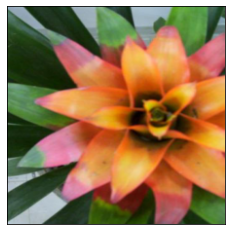

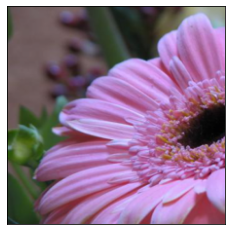

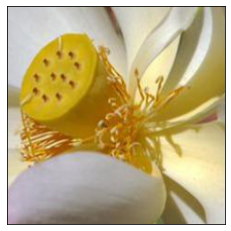

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(images[0])
imshow(images[1])
imshow(images[2])
print(len(images))

In the dataLoader, I tried to use batch_size bigger than 16 but I got a Google Collab size error due to the pre trained model I will use below.

**2 - BASELINE Model definition**

***First Attempt - BASELINE Model Definition and training***

As a first attempt, I tried to make my own Network (Classfifier Class).
The problem was that training is really long and results are not so brilliant.
I tried a lot of combinaison for my network. Some of them finish with a bit of results but nothing that can be used. And I totally forget which combinaison achieve the "good results" and i let the paremeters where i stopped to try my own model and change for transfer learning but it was around 1.2 of training loss after long time of training so nothing important anyway.

You can see below one of the Network I tried and noticed the bad results on this one. (For example, I change the number of convolutional Layer, full conected layer, I added and removed Batch Normalization, and dropout, I use different optimizer etc..)

Biggest problem is time, I never let the network train more than an hour if I didn't saw a really good increase in results.

Below you can check training my Network(Classifier) and my training Steps.
After that You will have the **Second Attempt** with Transfer Learning.

**I totally agree that i could have removed that from the notebook but i just wanted to show that i tried something before the transfer learning.**

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64*53*53, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 102)
        self.bn1 = nn.BatchNorm1d(2048)
        self.bn2 = nn.BatchNorm1d(1024)
        self.bn3 = nn.BatchNorm1d(512)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print('a', x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('b', x.shape)
        x = x.view(-1, 64*53*53)
        #print('c', x.shape)
        x = self.bn1(F.relu(self.fc1(x)))
        #print('d', x.shape)
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.bn3(F.relu(self.fc3(x)))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Classifier()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [ ]:
epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)    
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for images, labels in testloader:
              images = images.to(device)
              labels = labels.to(device)
              log_ps = model(images)
              loss = criterion(log_ps, labels)
              test_loss += loss.item()
              ps = torch.exp(log_ps)
              top_p, top_class = ps.topk(1, dim=1)
              equals = top_class == labels.view(*top_class.shape)
              accuracy = torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)))

Epoch: 1/30..  Training Loss: 3.886..  Test Loss: 3.568.. 
Epoch: 2/30..  Training Loss: 3.395..  Test Loss: 3.212.. 
Epoch: 3/30..  Training Loss: 3.146..  Test Loss: 3.007.. 
Epoch: 4/30..  Training Loss: 2.969..  Test Loss: 2.855.. 
Epoch: 5/30..  Training Loss: 2.800..  Test Loss: 2.772.. 
Epoch: 6/30..  Training Loss: 2.711..  Test Loss: 2.655.. 
Epoch: 7/30..  Training Loss: 2.616..  Test Loss: 2.642.. 
Epoch: 8/30..  Training Loss: 2.551..  Test Loss: 2.407.. 
Epoch: 9/30..  Training Loss: 2.407..  Test Loss: 2.420.. 
Epoch: 10/30..  Training Loss: 2.365..  Test Loss: 2.596.. 
Epoch: 11/30..  Training Loss: 2.465..  Test Loss: 2.699.. 
Epoch: 12/30..  Training Loss: 2.527..  Test Loss: 3.322.. 
Epoch: 13/30..  Training Loss: 2.344..  Test Loss: 2.462.. 
Epoch: 14/30..  Training Loss: 2.288..  Test Loss: 2.313.. 
Epoch: 15/30..  Training Loss: 2.179..  Test Loss: 3.488.. 
Epoch: 16/30..  Training Loss: 2.186..  Test Loss: 5.621.. 
Epoch: 17/30..  Training Loss: 2.267..  Test Loss

***Second Attempt - Transfer Learning - Model Definition***

For the second attempt I decided to use Transfer Learning Methods.

I tried 3 Pre-trained models. At first Densenet121 and 201 as seen in the labs. For both of them I had pretty good results (around 84% of accuracy, even with finetuning differents as in the labs and changing the transforms methods, optimizer etc). I wanted to go further and try ResNet or InceptionV3 and discuss with a friend about it and he talked me about **EfficientNet**.

https://github.com/lukemelas/EfficientNet-PyTorch

So I let you check below the results i Had with this Network.

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=3651c8d717217fb3b60a926bd9c1e3e8d7f3df2a8e9fcc1af2e76384b71d7fa5
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelEff = EfficientNet.from_pretrained('efficientnet-b7')
for param in modelEff .parameters():
    param.requires_grad = True
modelEff.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1000, 650)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(650, 300)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(300, 102)),
                          ('dropout', nn.Dropout(p=0.10)),
                          ('output', nn.Sigmoid())
                          ]))
criterion = nn.CrossEntropyLoss()
modelEff.to(device)
optimizer =  optim.Adam(modelEff.parameters(), lr=0.0001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7


In [ ]:
modelEff

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

**3 - Model training**

In [ ]:
epochs = 10
steps = 0
running_loss = 0
print_every = 175
tr_loss, te_loss = [], []
for e in range(epochs):
    for images, labels in trainloader:
        steps += 1
        print('cc: ', images)
        print('cc2: ', labels)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = modelEff(images)
        
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            print(steps)
            test_loss = 0
            accuracy = 0
            modelEff.eval()
            with torch.no_grad():
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    print('cc3: ', images)
                    print('cc4: ', labels)
                    log_ps = modelEff(images)
                    test_loss += criterion(log_ps, labels)
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
            tr_loss.append(running_loss/print_every)
            te_loss.append(test_loss/len(testloader))
            print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            modelEff.train()

cc:  tensor([[[[-0.2171, -0.2856, -0.2513,  ..., -0.4397, -0.4054, -0.3027],
          [ 0.0056, -0.0287,  0.0227,  ..., -0.4739, -0.4397, -0.3541],
          [ 0.3138,  0.2111,  0.1768,  ..., -0.5424, -0.4568, -0.3712],
          ...,
          [-0.6281, -0.5938, -0.4911,  ..., -0.3541, -0.4054, -0.4054],
          [-0.6452, -0.5938, -0.4911,  ..., -0.4739, -0.4911, -0.5253],
          [-0.5596, -0.5253, -0.4568,  ..., -0.4568, -0.4054, -0.4226]],

         [[-0.6702, -0.7052, -0.6527,  ...,  0.1877,  0.0126, -0.0924],
          [-0.1800, -0.1275, -0.0224,  ...,  0.1176, -0.0749, -0.1625],
          [ 0.5553,  0.6254,  0.7479,  ..., -0.0049, -0.1450, -0.1625],
          ...,
          [ 0.5378,  0.5203,  0.5553,  ...,  0.4153,  0.3102,  0.1702],
          [ 0.5553,  0.5378,  0.5553,  ..., -0.0399, -0.1275, -0.2150],
          [ 0.6078,  0.5903,  0.5553,  ..., -0.2850, -0.3200, -0.3375]],

         [[-0.4101, -0.4624, -0.4275,  ..., -0.2184, -0.1138,  0.1128],
          [-0.0615, -0.04

KeyboardInterrupt: ignored

**At first I just had increase the performance a little, but after some fineTuning i got around 0.16 of Loss and ~95% of accuracy.**

I got some trouble because of the requires_grad params and on fineTuning who was kind of long, I tested a lot of different parameters. But still the training and switch of parameters were 100* times easier and faster than with my own network that I finally gave up.

I also had to decrease my batch size because GoogleCollab was out of memory. It happens me once with this batch size(16) that i had error memory but i reinited the core and it was good.

**4 - Model evaluation after training**

As we can see, both Training and Test Loss looks decreasing together so possibility of overfitting are really weak.

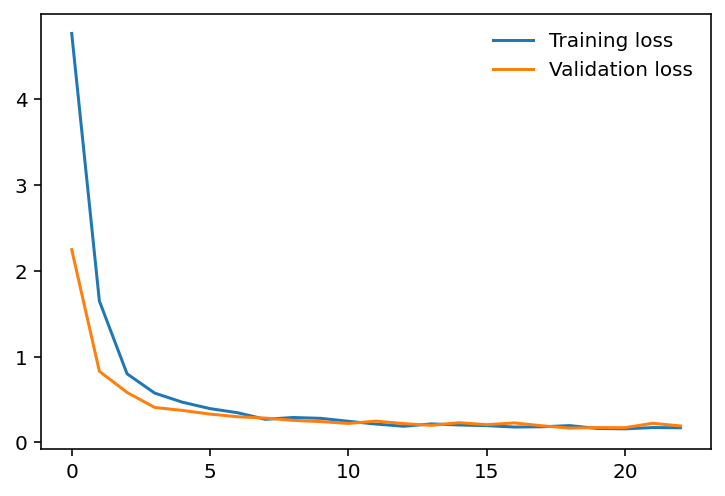

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(tr_loss, label='Training loss')
plt.plot(te_loss, label='Validation loss')
plt.legend(frameon=False)

I'm gonna test on image below:

99.89542961120605 % of probabilities for purple coneflower
 0.002949728150269948 % of probabilities for oxeye daisy
 0.002623547516122926 % of probabilities for common dandelion
 0.002278577630931977 % of probabilities for blanket flower
 0.0018830465705832466 % of probabilities for gaura


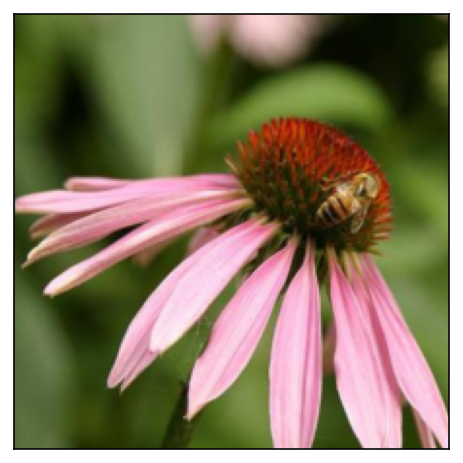

In [ ]:
## IMPORTANT ##
#It happened once to me that the predicted label is out of range (more than 102), 
#it happens only once so probably i've corrected the error after but in case it happens, just re-launch the bloc.


import numpy as np
from torch.autograd import Variable
from PIL import Image
import json

topk_list = {'names': [], 'proba':[]}
Newtestloader = torch.utils.data.DataLoader(test_data, batch_size=150)
idx_to_class = {val: key for key, val in test_data.class_to_idx.items()}
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

modelEff.eval()
dataiter = iter(Newtestloader)
images, labels = dataiter.next()
images = images.to(device)

img = images[randint(0, 149)]
with torch.no_grad():
    output = modelEff.forward(img.unsqueeze(0))
for idx in torch.topk(output, k=5).indices.squeeze(0).tolist():
    prob = torch.softmax(output, dim=1)[0, idx].item()
    topk_list['names'].append(cat_to_name[idx_to_class[idx]])
    topk_list['proba'].append(prob*100)
print("{} % of probabilities for {}\n".format(topk_list['proba'][0], topk_list['names'][0]),
      "{} % of probabilities for {}\n".format(topk_list['proba'][1], topk_list['names'][1]),
      "{} % of probabilities for {}\n".format(topk_list['proba'][2], topk_list['names'][2]),
      "{} % of probabilities for {}\n".format(topk_list['proba'][3], topk_list['names'][3]),
      "{} % of probabilities for {}".format(topk_list['proba'][4], topk_list['names'][4]),)
imshow(img.cpu())

If you want to change de input images to check others, 

**5 - Model qualitative analysis (on some examples)**

**Here around 92 and 94% with different transfer Learning methods :**

https://github.com/psatler/PyTorch_Challenge_Image_Classifier/blob/master/Facebook_PyTorch%60s_Challenge_Image_Classifier_Project.ipynb

**Searching for others  examples i founded some Notebook on kaggle around 94/98 of validation :**

https://www.kaggle.com/c/oxford-102-flower-pytorch/notebooks

I guess my Transfer Learning is pretty good as i have passed the 95% of validation and on all the others project i've seen on this dataset, the accuracy was around 94/98. I think the quality of my model is relevant and that i achieved my objectives.

**6 - Observations and comments**

As conclusion, I will say that for a classifier of this size (102 classes), the possibility of creating your own network could be a good Idea if you want to train your skills. In opposition, you should wait a lot of time if you want good results and as a beginner you'll lose a lot of time not only on training but also on the definition of the Network. What I understood after your courses, homework and on what i read, There is no network working good for every dataset, only experience can help you building you a good Network.
So if you want to have good results, trying to create network is productive for increasing your skills but using a pre-trained models and fine-tuning will allow you to have better results and understand more deep the creation and usage of a network.
